<a href="https://colab.research.google.com/github/aryan1429/deep-learning-lab/blob/main/DAE_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#Import Libraries
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import torch.optim as optim
from torch.utils.data import DataLoader

In [31]:
#Define Transformation
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5)) # Changed to single values for mean and std
])

In [32]:
#Download the datasets(train)(test)
train_data = datasets.MNIST(root = './data_mnist',download = True, train = True, transform = transforms)
test_data = datasets.MNIST(root = './data_mnist',download = True, train = False, transform = transforms)


In [33]:
#Data Loaders
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data,batch_size = 64 , shuffle =  False)

In [38]:
#Build the Architecture
class Denoise_AE(nn.Module):
  def __init__(self):
    super(Denoise_AE,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1,16,3,stride = 2,padding = 1),
        nn.ReLU(True),
        nn.Conv2d(16,32,3,stride = 2,padding = 1),
        nn.ReLU(True),
        nn.Conv2d(32,64,7)
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,7),
        nn.ReLU(True),
        nn.ConvTranspose2d(32,16,3,stride = 2,padding = 1,output_padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(16,1,3,stride = 2,padding = 1,output_padding = 1),
        nn.Sigmoid()
    )
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [39]:
#Object Creation
model = Denoise_AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

Denoise_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [40]:
#Adding Noise
def add_noise(img):
  noise = torch.randn(img.size()) * 0.5
  noise_img = img + noise
  noise_img = torch.clamp(noise_img, 0.,1.)
  return noise_img


In [41]:
for epoch in range(20):
  for data in train_loader:
    img,_ = data
    img = img.to(device)
    noisy_img = add_noise(img) # Add noise to the image
    output = model(noisy_img)
    loss = criterion(output,img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1,20,loss.item()))

epoch [1/20], loss:0.9254
epoch [2/20], loss:0.9317
epoch [3/20], loss:0.9261
epoch [4/20], loss:0.9253
epoch [5/20], loss:0.9230
epoch [6/20], loss:0.9279
epoch [7/20], loss:0.9187
epoch [8/20], loss:0.9227
epoch [9/20], loss:0.9237
epoch [10/20], loss:0.9228
epoch [11/20], loss:0.9221
epoch [12/20], loss:0.9289
epoch [13/20], loss:0.9200
epoch [14/20], loss:0.9234
epoch [15/20], loss:0.9221
epoch [16/20], loss:0.9202
epoch [17/20], loss:0.9243
epoch [18/20], loss:0.9232
epoch [19/20], loss:0.9214
epoch [20/20], loss:0.9254


In [46]:
#Reconstruct
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(img,cmap = 'gray'):
  npimg = img.numpy()
  plt.figure(figsize = (12,6))
  plt.imshow(np.transpose(npimg,(1,2,0)),cmap = cmap)
  plt.axis('off')
  plt.show()

torch.Size([96, 1, 28, 28])


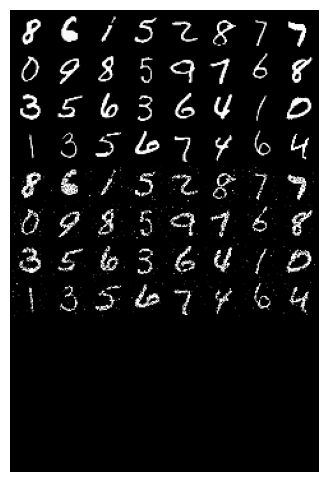

In [47]:
show_img = torch.cat([img,noisy_img,output],0)
show_img = show_img.cpu().detach()
print(show_img.shape)
imshow(torchvision.utils.make_grid(show_img),cmap = 'gray')